In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# kanama(mikroanevrizma),geçirgenlik(sert eksüda),anormal kılcallık(intaretinal mikrovasküler), büyük damarlar() 

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/aptos2019/train_1.csv", sep=",")
#csv dosyasında veriler , ile ayrıldığı için df'ye öyle aktardık
print(df.head())

        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0


<Axes: >

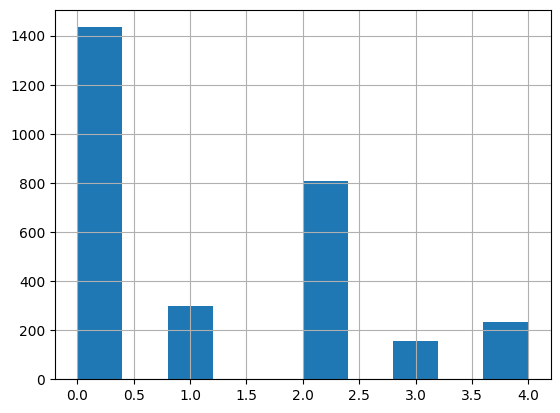

In [3]:
df["diagnosis"].hist()

In [4]:
df["diagnosis"].value_counts()

diagnosis
0    1434
2     808
1     300
4     234
3     154
Name: count, dtype: int64

* eğer veriseti karmaşık olursa
1. examp_df = pd.read_csv("test.csv")
2. examp_df = examp_df.sort_values(by= ["id_code"])

In [5]:
import os
path = "/kaggle/input/aptos2019/"

files = os.listdir(path + "train_images/train_images")
#print(files)

In [6]:
print(len(files))

2930


#her bir görseli okuma,yeniden boyutlama, cv2 görüntüyü alırken renk değişimi yaptığı için tekrar kendi haline getirme

In [7]:
import cv2
img_list=[]
for i in files[0:20]:
    image = cv2.imread(path + "/train_images/train_images/" + i)
    image = cv2.resize(image, (400,400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_list.append(image) 

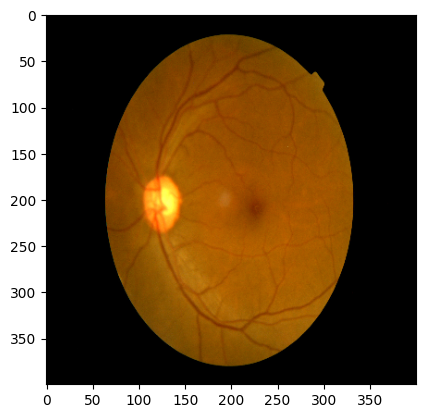

In [8]:
import matplotlib.pyplot as plt
plt.imshow(img_list[2])

Görüntülerde ki siyah alan farkları yüzünde model yanlış sonuçlar verir. Bunun önüne geçmek için(siyah alanları eşitleme) treshold işlemi yaparız.
**Treshol işlemi** : eşik değerin altını bir renk üstünü bir renk yapma. sonra eşik değerin altını maskeleriz.
1. Treshold işlemi için öncelikle görüntü gray formatta olmalı.
2. Gaussian: Bulanıklaştırma işlemi ile düşük ışıkta daha yüksek sonuç, bulanıklık artarsa kesinlik azalır
3. Treshold işlemi

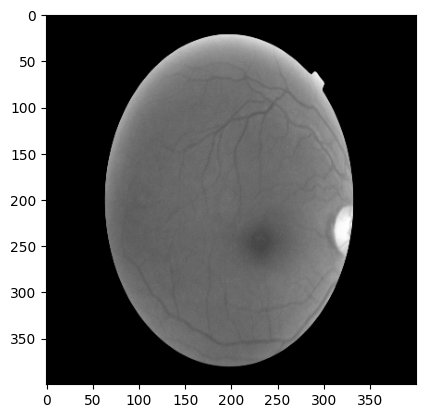

In [9]:
copy = img_list[4].copy()
copy = cv2.cvtColor(copy,cv2.COLOR_RGB2GRAY)
plt.imshow(copy, cmap="gray")

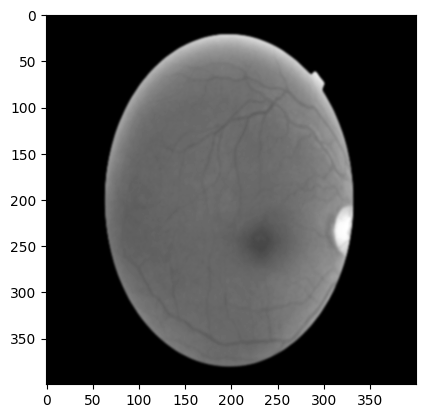

In [10]:
blur = cv2.GaussianBlur(copy, (5,5), 0)      # (image, kernel, sigmax,sigmay=genelde 0 )
plt.imshow(blur, cmap="gray")

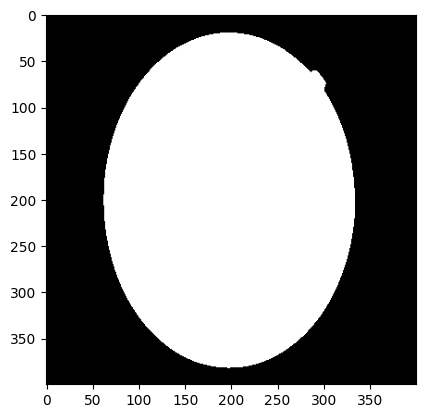

In [11]:
thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]  # (image, eşik değeri, max değer, treshold tipi)
plt.imshow(thresh, cmap="gray")

Görüntülerde ki siyah kısımları kırpma işlemi yapacağız. bunun için 
1. Kontür ile alanın belirlenmesi
2. Kırpma işlemi : bunun için 4 tane uç nokta gerekir 

In [12]:
kontur = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  #(image, kontür nasıl ayrılsın, kontür hatları(düzgün, belirsiz, ) )
kontur = kontur[0][0]   #shape (a,1,2)
kontur = kontur[:,0,:]  # veride boyut fazlalığını giderme shape(a,2)

In [13]:
kontur[:,0].argmax()   #argmax max değerin indeksini verir

343

In [14]:
kontur[335]            # sağ noktayı bulduk  

array([329, 248], dtype=int32)

In [15]:
kontur[:,0].argmin()

115

In [16]:
kontur[115]

array([ 62, 195], dtype=int32)

In [17]:
sol = tuple(kontur[kontur[:,0].argmin()])
sag = tuple(kontur[kontur[:,0].argmax()])
ust = tuple(kontur[kontur[:,1].argmin()])
alt = tuple(kontur[kontur[:,1].argmax()])

In [18]:
sag,sol,ust,alt

((333, 220), (62, 195), (188, 20), (196, 382))

In [19]:
x1 = sol[0]
y1 = ust[1]
x2 = sag[0]
y2 = alt [1]

In [20]:
x1,y1,x2,y2

(62, 20, 333, 382)

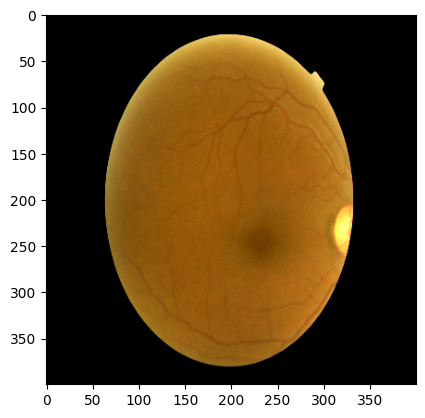

In [21]:
orj = img_list[4]
plt.imshow(orj)

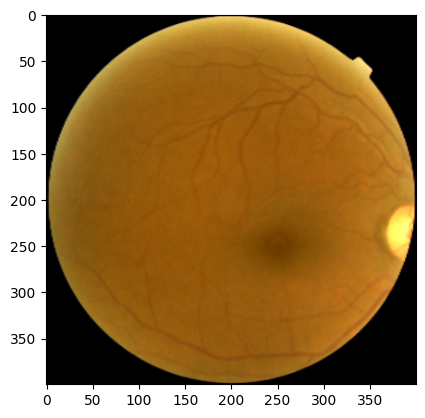

In [22]:
crop_orj = orj[y1:y2, x1:x2]
#plt.imshow(crop_orj)
# yapılan işlemde görsel küçüldüğü için yeniden eski boyuta
crop_orj = cv2.resize(crop_orj,(400,400))
plt.imshow(crop_orj)

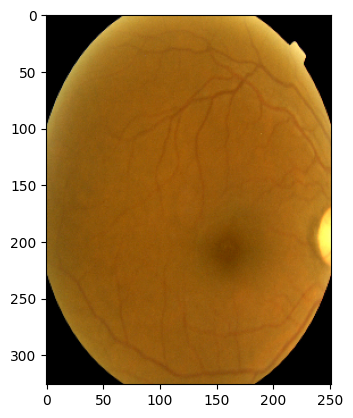

In [23]:
#görüntünün köşelirde hala siyah kısımlar var. son kez bir kırpma işlemi
x = int(x2-x1)*4//100
y = int(y2-y1)*5//100
crop_son = orj[y1+y:y2-y, x1+x:x2-x]
plt.imshow(crop_son)

Renk kanalları üzerinden görüntüyü iyileştirme yapacağız.
Clahe işlemi: Kontrast limitli adaptif histogram eşitleme. Limitin amacı kumlanmayı önlemek

In [24]:
lab = cv2.cvtColor(crop_son, cv2.COLOR_RGB2LAB)

In [25]:
lab.shape

(326, 251, 3)

In [26]:
l,a,b = cv2.split(lab)
print(l.shape,a.shape,b.shape)

(326, 251) (326, 251) (326, 251)


In [27]:
# görüntüyü histogram grafiğine vermeden önce düzleştirme işlemi yapacağız
duz = l.flatten()
duz.shape

(81826,)

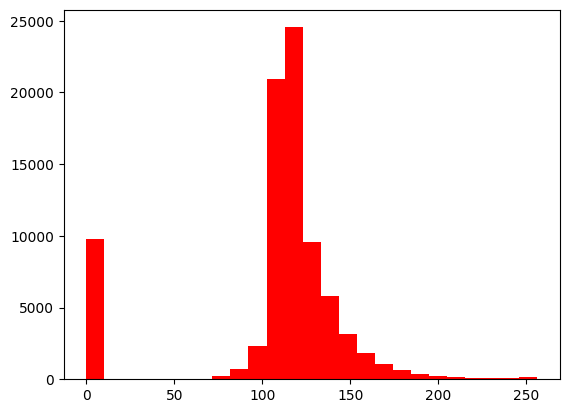

In [28]:
plt.hist(duz,25,[0,256], color="r")
plt.show()

görüntüye baktığımızda belirli bir aralık için yoğunlaşma görülür. bu durumda historam eşitleme yapmak daha çok zarar verir bunun yerine clache işlmi yapılır.

In [29]:
#yapılan işlem bir çerçevenin görselde gezmesi, gezerken piksel değeri 7 üzerinde ise yoğunluğu komşulara dağıtır
clahe = cv2.createCLAHE(clipLimit=7.0,tileGridSize=(8,8))   #(kontrast_limit, çerçeve_boyutu,)
cl = clahe.apply(l)

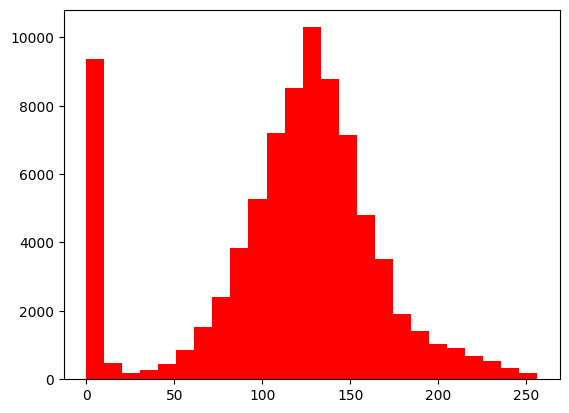

In [30]:
plt.hist(cl.flatten(),25,[0,256], color="r")
plt.show()

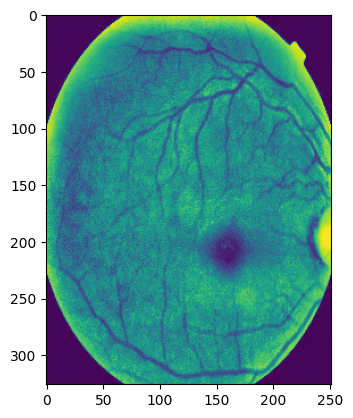

In [31]:
plt.imshow(cl)

In [32]:
limg = cv2.merge((cl,a,b))

In [33]:
son = cv2.cvtColor(crop_son,cv2.COLOR_LAB2RGB)

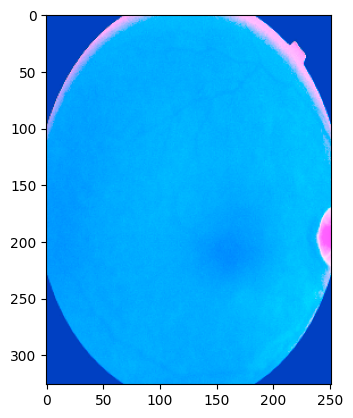

In [34]:
plt.imshow(son)

limiti düşük tutsakta kumlanma yine oldu. bunun için Median Blur yapacağız.Median BLUR: Çerçeve piksellerin ortalama değeri kullanarak görüntüyü iyileştirir.

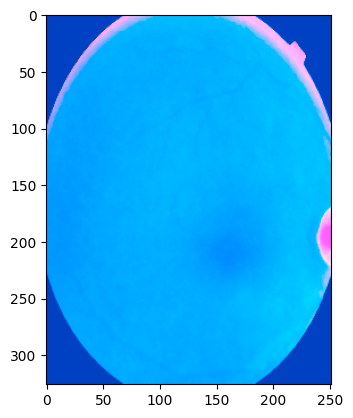

In [35]:
med_son = cv2.medianBlur(son,3)
plt.imshow(med_son)

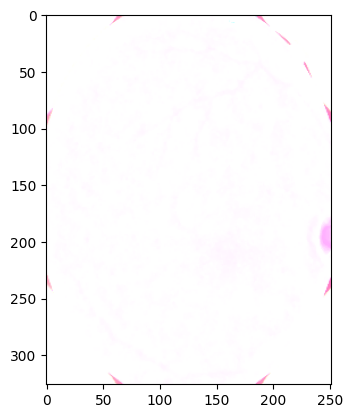

In [36]:
# gözde kanlanmış kısımları daha iyi görmek için maske ile netleştirme
#maske işlemi iki görüntüyü üst üste koyar bunun için görnütünün arkasına yoğun bir blur işlemi koyacağız
arka_plan = cv2.medianBlur(son, 37)
maske = cv2.addWeighted(med_son, 1, arka_plan, -1, 255)
plt.imshow(maske)

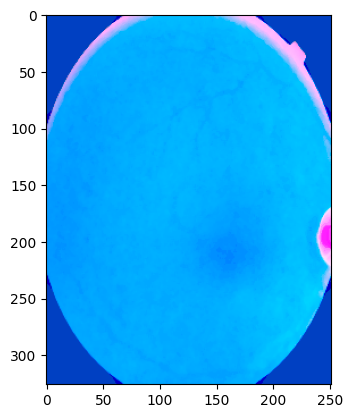

In [37]:
son_img = cv2.bitwise_and(maske, med_son)
plt.imshow(son_img)

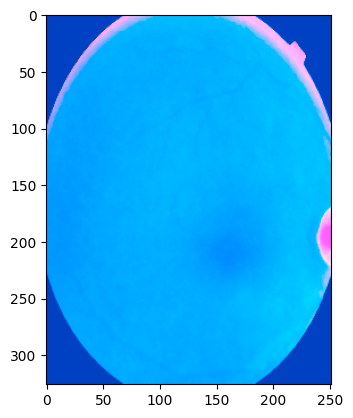

In [38]:
plt.imshow(med_son)

In [39]:
img_list = []


for i in files[0:20]:
    image = cv2.imread(path + "/train_images/train_images/" + i)
    image = cv2.resize(image,(400,400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    kopya = image.copy()
    kopya = cv2.cvtColor(kopya, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thresh = cv2.threshold(blur,10,255, cv2.THRESH_BINARY)[1]
    kontur = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kontur = kontur[0][0]
    kontur = kontur[:,0,:]
    x1 = tuple(kontur[kontur[:,0].argmin()])[0]
    y1 = tuple(kontur[kontur[:,1].argmin()])[1]
    x2 = tuple(kontur[kontur[:,0].argmax()])[0]
    y2 = tuple(kontur[kontur[:,1].argmax()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*5//50
    kopya2 = image.copy()
    #görsele kırpma yapılmışsa kırpma
    if x2-x1 >100 and y2-y1> 100:
        kopya2 = kopya2[y1+y : y2-y , x1+x : x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    lab = cv2.cvtColor(kopya2, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    son = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    med_son = cv2.medianBlur(son, 3)
    arka_plan = cv2.medianBlur(son, 37)
    maske = cv2.addWeighted(med_son,1,arka_plan,-1,255)
    son_img = cv2.bitwise_and(maske,med_son)
    img_list.append(son_img)

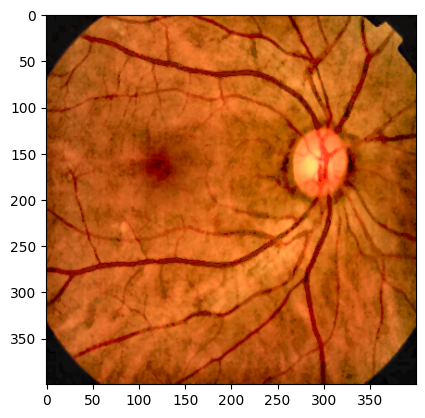

In [40]:
plt.imshow(img_list[3])

kodun ilerleyişini görmek istersek

from tqdm import tqdm_notebook as tqdm

for i in tqdm(files):

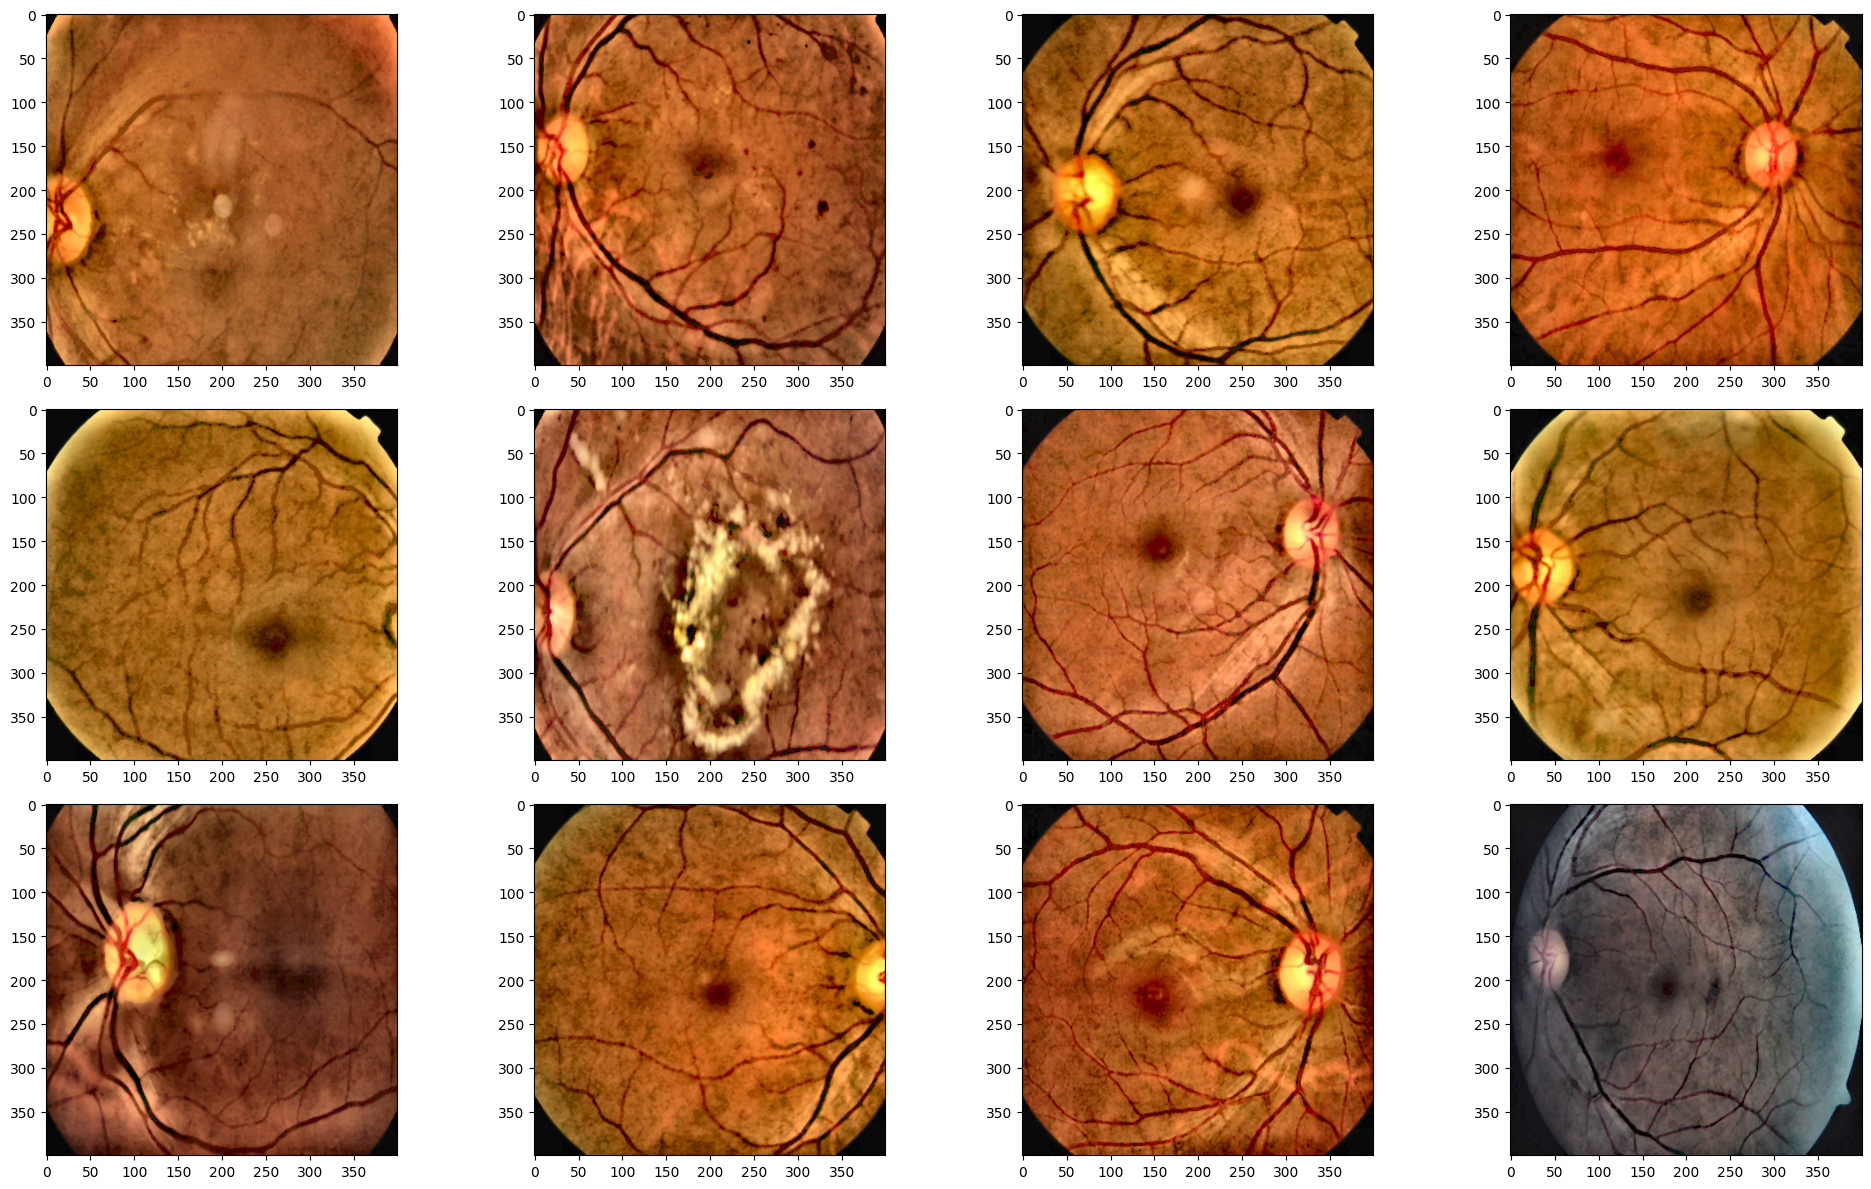

In [41]:
fig = plt.figure(figsize=(20,12))

for i in range(12):
    img = img_list[i]
    fig.add_subplot(3,4,i+1)
    plt.imshow(img)
plt.tight_layout()

In [42]:
#one hot encoding
df["diagnosis"]

0       2
1       1
2       4
3       0
4       0
       ..
2925    0
2926    0
2927    0
2928    0
2929    0
Name: diagnosis, Length: 2930, dtype: int64

In [43]:
y_train = pd.get_dummies(df['diagnosis']).values

In [44]:
print(df["diagnosis"][2])
print(y_train[2])

4
[False False False False  True]


In [45]:
y_train_son = np.ones(y_train.shape, dtype='uint8')
y_train_son[:,4] = y_train[:,4]

In [46]:
for i in range(3,-1,-1):
    y_train_son[:,i] = np.logical_or(y_train[:,i], y_train_son[:,i+1])

In [47]:
y_train_son

array([[1, 1, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

In [48]:
#print(img_list[0])
#print(type(img_list[0]))
x_train = np.array(img_list)   #liste formatındaki verileri array yapma
#print(x_train[0])
#print(type(x_train[0]))
print(type(img_list))
print(type(x_train))

<class 'list'>
<class 'numpy.ndarray'>


In [49]:
#boyut kontrol
print(y_train_son.shape)
print(x_train.shape)

(2930, 5)
(20, 400, 400, 3)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val , y_train, y_val = train_test_split(x_train,
                                                   y_train_son,
                                                   test_size=0.15,
                                                   random_state=2019,
                                                   shuffle=True)

In [ ]:
x_train.shape, x_val.shape , y_train.shape, y_val.shape

In [ ]:
#görüntüleri modele vermeden önce tensör haline getirme
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True) #veri arttırımı
data_generator = datagen.flow(x_train,y_train,batch_size=2,seed=2020) #tensör haline getirme
#kullanacağımız modelde ihtiyaç olmadığı için standartlaştırma yapmadık

In [ ]:
from efficientnet.keras import EfficientNetB5
ornek_model = EfficientNetB5(include_top=False)  #include_top : son katmanları çıkarır
ornek_model.summary()

In [ ]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(EfficientNetB5(weights='imagenet',include_top=False, input_shape=(400,400,3)))
model.add(layers.GlobalAveragePooling2D())  #parametre azaltma
model.add(layers.Dropout(0.5))              #overfiiting azaltma için
model.add(layers.Dense(5,activation = 'sigmoid'))

softmax çoklu sınıflandırmada sigmoid ikili sınıflandırmada kullanılır ancak
Multi-class : bir çok meyve, sadece bir bağıl - softmax  -
Multi-label : bir çok buzdolabı, birden çok bağıl  - sigmoid -loss:binary_cross

In [ ]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.00005),metrics=['accuracy'])

In [ ]:
#model hep aynı değeri vermeye başlarsa öğrenme kat sayısını azalt: overfitting önleme için
from keras.callbacks import ReduceLROnPlateau

lr = ReduceLROnPlateau(monitor = 'val_loss',
                      patience = 3,
                      verbose = 1,
                      mode='auto',
                      factor=0.25,
                      min_lr=0.000001)

In [ ]:
history = model.fit_generator(data_generator,
                             steps_per_epoch = 1000,
                             epochs = 1,
                             validation_data = (x_val,y_val),
                             callbacks = [lr])